In [2]:
# model like LeNet-5
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import copy
import time
import torch
import torch.nn as nn
from torch.optim import Adam
import torch.utils.data as Data
from torchvision import transforms
from torchvision.datasets import FashionMNIST

In [3]:
# 准备数据集
train_data = FashionMNIST(
    root = "./data/FashionMNIST",
    train = True,
    transform = transforms.ToTensor(),
    download = False
)
# 数据加载器
train_loader = Data.DataLoader(
    dataset = train_data,
    batch_size = 64,
    shuffle = False,
    num_workers = 2,
)
# 计算batch数
print("batch数: ", len(train_loader))

batch数:  938


batch_x.shape:  (64, 28, 28)
batch_y.shape:  (64,)


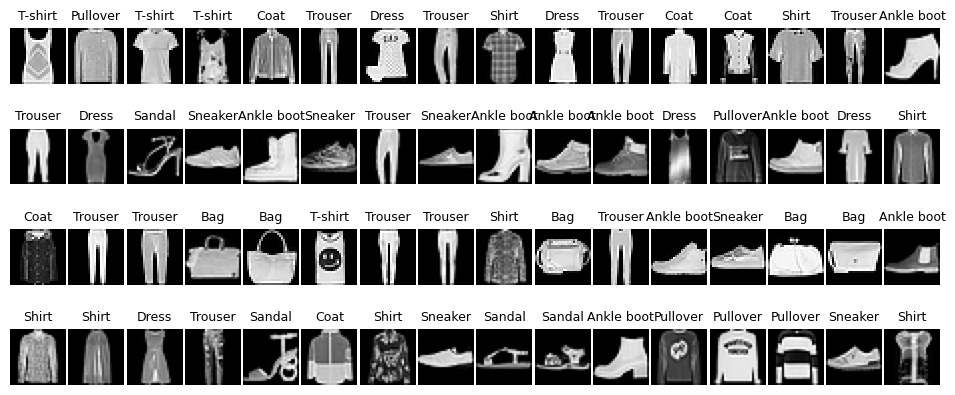

In [4]:
# 获得一个batch的数据
for step, (b_x, b_y) in enumerate(train_loader):
    if step > 0:
        break
# 可视化一个batch的图像
batch_x = b_x.squeeze().numpy()
print("batch_x.shape: ", batch_x.shape)
batch_y = b_y.numpy()
print("batch_y.shape: ", batch_y.shape)
class_label = train_data.classes
class_label[0] = "T-shirt"
plt.figure(figsize=(12, 5))
for ii in np.arange(len(batch_y)):
    plt.subplot(4, 16, ii+1)
    plt.imshow(batch_x[ii,:,:], cmap=plt.cm.gray)
    plt.title(class_label[batch_y[ii]], size=9)
    plt.axis("off")
    plt.subplots_adjust(wspace=0.05)

In [5]:
# 测试集
test_data = FashionMNIST(
    root = "./data/FashionMNIST",
    train = False,
    download = False
)
# 添加一个通道维度，并将取值缩放到0~1
test_data_x = test_data.data.type(torch.FloatTensor) / 255.0
test_data_x = torch.unsqueeze(test_data_x, dim=1)      # (n, 1, w , h)
test_data_y = test_data.targets
print("test_data_x.shape: ", test_data_x.shape)
print("test_data_y.shape: ", test_data_y.shape)

test_data_x.shape:  torch.Size([10000, 1, 28, 28])
test_data_y.shape:  torch.Size([10000])


In [6]:
# 搭建卷积神经网络
class MyConvNet(nn.Module):
    def __init__(self):
        super(MyConvNet, self).__init__()
        # Conv1
        self.conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels=1,
                out_channels=16,
                kernel_size=3,
                stride=1,
                padding=1,
            ),                        # 卷积后 (1*28*28)->(16*28*28) w=(w'+2*padding-dilation*(kernelsize-1)-1)/stride+1=(28+2*1-1*(3-1)-1)/1+1=28
            nn.ReLU(),
            nn.AvgPool2d(
                kernel_size=2,
                stride=2,
            ),                        # 池化后 (16*28*28)->(16*14*14) w=(w'-(kernelsize-1)-1)/stride+1=(28-(2-1)-1)/2+1=14
        )
        # Conv2
        self.conv2 = nn.Sequential(
            nn.Conv2d(
                in_channels=16,
                out_channels=32,
                kernel_size=3,
                stride=1,
                padding=0,
            ),                        # 卷积后 (16*14*14)->(32*12*12) w=(w'+2*padding-dilation*(kernelsize-1)-1)/stride+1=(14+2*0-1*(3-1)-1)/1+1=12
            nn.ReLU(),
            nn.AvgPool2d(
                kernel_size=2,
                stride=2,
            ),                        # 池化后 (32*12*12)->(32*6*6) w=(w'-(kernelsize-1)-1)/stride+1=(12-(2-1)-1)/2+1=6
        )
        self.classifier = nn.Sequential(
            nn.Linear(32*6*6, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 10),
        )
    # 前向传播路径
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.size(0), -1)  # 展开多维的卷积图层
        output = self.classifier(x)
        return output

# 输出网络结构
myconvnet = MyConvNet()
print(myconvnet) 

MyConvNet(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  )
  (classifier): Sequential(
    (0): Linear(in_features=1152, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=10, bias=True)
  )
)


In [7]:
# 卷积神经网络的训练
def train_model(model, traindataloader, train_rate, criterion, optimizer, num_epochs=25):
    """
    model:网络模型
    traindataloader:训练数据集加载器
    train_rate:训练集batchsize百分比
    criterion:损失函数
    optimizer:优化方法
    num_epochs:训练的代数
    """
    # 计算训练所需要的batch数
    batch_num = len(traindataloader)
    train_batch_num = round(batch_num * train_rate)
    # 复制模型的参数
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    train_loss_all = []
    train_acc_all = []
    val_loss_all = []
    val_acc_all = []
    since = time.time()
    for epoch in range(num_epochs):
        print("Epoch {}/{}".format(epoch, num_epochs - 1))
        print('-' * 10)
        # 每个epoch分为训练阶段和评估阶段
        train_loss = 0.0
        train_corrects = 0
        train_num = 0
        val_loss = 0.0
        val_corrects = 0
        val_num = 0
        for step, (b_x, b_y) in enumerate(traindataloader):
            if step < train_batch_num:
                model.train()
                output = model(b_x)
                pre_lab = torch.argmax(output, 1)
                loss = criterion(output, b_y)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                train_loss += loss.item() * b_x.size(0)
                train_corrects += torch.sum(pre_lab == b_y.data)
                train_num += b_x.size(0)
            else:
                model.eval()
                output = model(b_x)
                pre_lab = torch.argmax(output, 1)
                loss = criterion(output, b_y)
                val_loss += loss.item() * b_x.size(0)
                val_corrects += torch.sum(pre_lab == b_y.data)
                val_num += b_x.size(0)
        # 计算一个epoch在训练集和验证集上的损失和精度
        train_loss_all.append(train_loss / train_num)
        train_acc_all.append(train_corrects.double().item() / train_num)
        val_loss_all.append(val_loss / val_num)
        val_acc_all.append(val_corrects.double().item() / val_num)
        print('{} Train Loss: {:.4f} Train Acc: {:.4f}'.format(epoch, train_loss_all[-1], train_acc_all[-1]))
        print('{} Val Loss: {:.4f} Val Acc: {:.4f}'.format(epoch, val_loss_all[-1], val_acc_all[-1]))
        # 拷贝模型最高精度下的参数
        if val_acc_all[-1] > best_acc:
            best_acc = val_acc_all[-1]
            best_model_wts = copy.deepcopy(model.state_dict())
        time_use = time.time() - since
        print("Train and Val complete in {:.0f}m {:.0f}s".format(time_use // 60, time_use % 60))
    # 使用模型最好的参数
    model.load_state_dict(best_model_wts)
    train_process = pd.DataFrame(
        data = {
            "epoch":range(num_epochs),
            "train_loss_all":train_loss_all,
            "val_loss_all":val_loss_all,
            "train_acc_all":train_acc_all,
            "val_acc_all":val_acc_all
        }
    )
    return model, train_process                

In [ ]:
# 对模型进行训练
optimizer = torch.optim.Adam(myconvnet.parameters(), lr=0.0003)
criterion = nn.CrossEntropyLoss()
myconvnet, train_process = train_model(myconvnet, train_loader, 0.8, criterion, optimizer, num_epochs=25)

Epoch 0/24
----------
0 Train Loss: 0.7767 Train Acc: 0.7196
0 Val Loss: 0.5595 Val Acc: 0.7826
Train and Val complete in 0m 16s
Epoch 1/24
----------
1 Train Loss: 0.5101 Train Acc: 0.8100
1 Val Loss: 0.4657 Val Acc: 0.8327
Train and Val complete in 0m 31s
Epoch 2/24
----------
2 Train Loss: 0.4415 Train Acc: 0.8382
2 Val Loss: 0.4204 Val Acc: 0.8487
Train and Val complete in 0m 46s
Epoch 3/24
----------
3 Train Loss: 0.3999 Train Acc: 0.8541
3 Val Loss: 0.3951 Val Acc: 0.8572
Train and Val complete in 1m 2s
Epoch 4/24
----------
4 Train Loss: 0.3700 Train Acc: 0.8656
4 Val Loss: 0.3721 Val Acc: 0.8659
Train and Val complete in 1m 17s
Epoch 5/24
----------
5 Train Loss: 0.3469 Train Acc: 0.8733
5 Val Loss: 0.3546 Val Acc: 0.8722
Train and Val complete in 1m 33s
Epoch 6/24
----------


In [ ]:
# 可视化模型训练过程
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_process.epoch, train_process.train_loss_all, "ro-", label="Train loss")
plt.plot(train_process.epoch, train_process.val_loss_all, "bs-", label="Val loss")
# plt.legend()
plt.xlabel("epoch")
plt.ylabel("Loss")
plt.subplot(1, 2, 2)
plt.plot(train_process.epoch, train_process.train_acc_all, "ro--", label="Train acc")
plt.plot(train_process.epoch, train_process.val_acc_all, "bs--", label="Val acc")
plt.legend()
plt.xlabel("epoch")
plt.ylabel("Acc")
plt.show()

In [ ]:
# 对测试集进行预测，并可视化预测效果
myconvnet.eval()
output = myconvnet(test_data_x)
pre_lab = torch.argmax(output, 1)
acc = accuracy_score(test_data_y, pre_lab)
print("在测试集上的预测精度为:", acc)

In [ ]:
# 计算混淆矩阵并可视化
conf_mat = confusion_matrix(test_data_y, pre_lab)
df_cm = pd.DataFrame(conf_mat, index=class_label, columns=class_label)
heatmap = sns.heatmap(df_cm, annot=True, fmt="d", cmap="YlGnBu")
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha="right")
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha="right")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()